In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import glob
import seaborn as sns

In [2]:
##CARGANDO TRANSFERENCIAS

path = "C:\\Users\\jloayzap\\Documents\\JLP\\ANALISIS_OPERACIONES\\TRANSFERENCIAS"

filenames = glob.glob(path + "\*.xlsx")
#print('File names:', filenames)
df_trans = pd.DataFrame()

for f in filenames:
    data = pd.read_excel(f, 'Hoja1', converters={'Número Unico de Operación':str})
    df_trans = df_trans.append(data)
    
df_trans['CCI_Destino_2'] = np.where(df_trans['CCI Destino'].str.len() == 20, df_trans['CCI Destino'], '0' + df_trans['CCI Destino'].astype(str))
df_trans["ANIO"] = df_trans['Fecha Presentación'].str[:4] 
df_trans["MES"] = df_trans['Fecha Presentación'].str[5:7]
df_trans['ANIOMES'] = df_trans['ANIO'].astype(str) + df_trans['MES'].astype(str)
df_trans["Importe Transferencia"] = df_trans.rename(columns={'Importe Transferencia':'IMPORTE'}, inplace = True)
df_trans['IMPORTE_FINAL'] = df_trans['IMPORTE'].astype(float)

In [3]:
##PARTICIONANDO BASE 
#ENTRADAS
df_trans_ent = df_trans[df_trans['Transferencia'] == 'E - ENTR']
df_trans_ent = df_trans_ent[df_trans_ent.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]

#SALIDAS
df_trans_sal = df_trans[df_trans['Transferencia'] == 'S - SALID']
df_trans_sal = df_trans_sal[df_trans_sal.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]

In [4]:
##CARGANDO SALDOS
df_saldos = pd.read_csv("C:\\Users\\jloayzap\\Documents\\JLP\\SALDOS_MOVIMIENTO\\SALDOS\\Saldos.csv", sep = ";", converters={'NROCUENTA':str, 'NUMERODOCUMENTO':str, 'CCICODE':str})

C:\Users\jloayzap\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (23,29,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


****TRABAJANDO CON TRANSFERENCIAS ENTRADAS****

In [5]:
#Obteniendo DNI Clientes
##OBTENIENDO DNI CIENTE DESDE BASE DE SALDOS
df_trans_ent = df_trans_ent.merge(df_saldos[['CCICODE', 'TIPODOCUMENTO', 'NUMERODOCUMENTO']], left_on ='CCI_Destino_2', right_on='CCICODE', how='left')
df_trans_ent.head()

,Transferencia,Fecha Presentación,Fecha Liquidación,Sesión,Moneda,IMPORTE,Comisión Interbancaria,Comisión Cliente,Comisión Rechazo Cliente,Itf Transferencia,...,Secuencia Transf. Multiples,CCI_Destino_2,ANIO,MES,ANIOMES,Importe Transferencia,IMPORTE_FINAL,CCICODE,TIPODOCUMENTO,NUMERODOCUMENTO
0,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,187.76,0.0,0.0,0,0.0,...,NaN,05410780010085561386,2021,08,202108,None,187.76,05410780010085561386,1.0,08269277
1,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,95.00,0.0,0.0,0,0.0,...,NaN,05488882888002871732,2021,08,202108,None,95.00,05488882888002871732,1.0,41300587
2,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,350.00,0.0,0.0,0,0.0,...,NaN,05430180010043326077,2021,08,202108,None,350.00,05430180010043326077,1.0,18078194
3,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,34.00,0.0,0.0,0,0.0,...,NaN,05431480010032842201,2021,08,202108,None,34.00,05431480010032842201,1.0,40744416
4,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,210.00,0.0,0.0,0,0.0,...,NaN,05460280010115910780,2021,08,202108,None,210.00,05460280010115910780,1.0,45008527


In [7]:
grupo = pd.DataFrame()
grupo = df_trans_ent.groupby(['NUMERODOCUMENTO', 'ANIOMES']).NUMERODOCUMENTO.size()
df_trans_ent_grupo = pd.DataFrame(grupo.reset_index(name='CUENTA_OP'))
df_trans_ent_grupo.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_ent_grupo['LLAVE'] = df_trans_ent_grupo['NUMERODOCUMENTO'].astype(str) + df_trans_ent_grupo['ANIOMES'].astype(str)

grupo = pd.DataFrame()
grupo = df_trans_ent.groupby(['NUMERODOCUMENTO', 'ANIOMES']).IMPORTE.sum()
df_trans_ent_sum = pd.DataFrame(grupo.reset_index(name='SUMA_OP'))
df_trans_ent_sum.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_ent_sum['LLAVE'] = df_trans_ent_sum['NUMERODOCUMENTO'].astype(str) + df_trans_ent_sum['ANIOMES'].astype(str)

df_trans_ent_grupo_sum = df_trans_ent_grupo.merge(df_trans_ent_sum.drop_duplicates(subset=['LLAVE'])[['LLAVE', 'SUMA_OP']], left_on ='LLAVE', right_on='LLAVE', how='inner')
df_trans_ent_grupo_sum.sort_values(['CUENTA_OP', 'SUMA_OP'], ascending=False)

,NUMERODOCUMENTO,ANIOMES,CUENTA_OP,LLAVE,SUMA_OP
107700,47398435,202203,225,47398435202203,31361.00
130121,76295926,202109,166,76295926202109,164364.72
46430,40210037,202108,160,40210037202108,55400.00
92380,45432938,202203,142,45432938202203,49840.58
121171,72158986,202203,142,72158986202203,32969.10
...,...,...,...,...,...
128482,75404175,202201,1,75404175202201,0.01
128622,75459614,202203,1,75459614202203,0.01
129670,76054106,202111,1,76054106202111,0.01
129679,76059119,202201,1,76059119202201,0.01


In [8]:
df_trans_ent_grupo_sum_unico = df_trans_ent_grupo_sum[df_trans_ent_grupo_sum['CUENTA_OP'] == 1]
df_trans_ent_grupo_sum_mul = df_trans_ent_grupo_sum[df_trans_ent_grupo_sum['CUENTA_OP'] > 1]

Validar 4 tipologías 
 - Transferencias entradas montos unicos
 - Transferencias entradas montos multiples
 - Transferencias salidas montos unicos
 - Transferencias salidas montos multiples     

**PARTICIANDO DATAFRAME SEGUN EL MES Y AÑO**
 - Utilizamos la función locals para generar dataframes dinamicos)

In [9]:
#Particionar Dataframe df_trans_ent_grupo_sum_unico
for i, (ID, subdf) in enumerate(df_trans_ent_grupo_sum_unico.groupby('ANIOMES'), 1):
    locals()[f'df{ID}'] = subdf

In [184]:
#Particionar Dataframe df_trans_ent_grupo_sum_mult
for i, (ID, subdf) in enumerate(df_trans_ent_grupo_sum_mul.groupby('ANIOMES'), 1):
    locals()[f'df_mult{ID}'] = subdf

**PRUEBA DE GENERACIÓN MULTIPLES DATAFRAME DE FRECUENCIAS**

In [10]:
##Generando multiples frecuencias

# import math

# #Creando lista con los grupos
# dataframes_valores_prueba = df_trans_ent_grupo_sum_unico.ANIOMES.unique()

# for i in dataframes_valores_prueba:
#     #print(locals()[f'df{i}']['SUMA_OP'])
#     #print ([f'df{i}'])
    
#     pd.set_option('precision', 2)
#     datos = locals()[f'df{i}']['SUMA_OP'].astype(float)

#     # Cálculo del número de intervalos
#     # Si la parte entera de k es un número impar, redondeamos a la baja
#     k = 1 + 3.322 * math.log10(len(datos))
#     numero = int(k)
#     if numero % 2 == 0:
#         periodos = math.ceil(k)
#     else:
#         periodos = int(k)

#     inf = datos.min()        # Limite inferior del primer intervalo
#     dif = datos.max()
#     sup = datos.max() + 1    # Limite superior del último intervalo

#     intervals = pd.interval_range(
#         start=inf,
#         end=sup,
#         periods=k,
#         name="Intervalo",
#         closed="left")

#     locals()[f'df_frec_{i}'] = pd.DataFrame(index=intervals)
#     locals()[f'df_frec_{i}']["FreqAbs"] = pd.cut(datos, bins=locals()[f'df_frec_{i}'].index).value_counts()
#     locals()[f'df_frec_{i}']["Marca"]  = locals()[f'df_frec_{i}'].index.mid

# #Imprimir Dataframe particionado distribución
# from IPython.display import display

# for i in dataframes_valores_prueba:
#     print (i)
#     display(locals()[f'df_frec_{i}'])

***PRUEBA MANUAL TABLA + HISTOGRAMA***

In [ ]:
# ###PRUEBA MANUAL

# import math
# import matplotlib.pyplot as plt
# from matplotlib.ticker import StrMethodFormatter

# ####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
# datos = df202108['SUMA_OP'].astype(float)

# k = int(1 + 3.322 * math.log10(len(datos)))

# inf = datos.min()        # Limite inferior del primer intervalo
# dif = datos.max()
# sup = datos.max() + 1    # Limite superior del último intervalo

# intervals = pd.interval_range(
#     start=inf,
#     end=sup,
#     periods=k,
#     name="Intervalo",
#     closed="left")

# lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

# ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
# df202108_lim_excluir = df202108[df202108['SUMA_OP'] >= lim_excluir]

# ###OBTENIENDO LOS K 
# k = int(1 + 3.322 * math.log10(len(df202108_lim_excluir['SUMA_OP'].astype(float))))

# ###GENERANDO EL HISTOGRAMA
# ax = df202108_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

# ax = ax[0]
# for x in ax:

#     # Despine
#     x.spines['right'].set_visible(True)
#     x.spines['top'].set_visible(True)
#     x.spines['left'].set_visible(True)

#     # Switch off ticks
#     x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#     # Draw horizontal axis lines
#     vals = x.get_yticks()
#     for tick in vals:
#         x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

#     # Remove title
#     x.set_title("")

#     # Set x-axis label
#     x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

#     # Set y-axis label
#     x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

#     # Format y-axis label
#     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# ## Imprimiendo Dataframe frecuencias
# pd.set_option('precision', 2)
# datos2 = df202108_lim_excluir['SUMA_OP'].astype(float)

#     # Cálculo del número de intervalos
#     # Si la parte entera de k es un número impar, redondeamos a la baja
# k = 1 + 3.322 * math.log10(len(datos2))
# numero = int(k)
# if numero % 2 == 0:
#     periodos = math.ceil(k)
# else:
#     periodos = int(k)

# inf = datos2.min()        # Limite inferior del primer intervalo
# dif = datos2.max()
# sup = datos2.max() + 1    # Limite superior del último intervalo

# intervals = pd.interval_range(
#     start=inf,
#     end=sup,
#     periods=k,
#     name="Intervalo",
#     closed="left")

# df202108_lim_excluir_frec = pd.DataFrame(index=intervals)
# df202108_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df202108_lim_excluir_frec.index).value_counts()
# df202108_lim_excluir_frec["Marca"]  = df202108_lim_excluir_frec.index.mid

# display(df202108_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO CONSOLLIDADO DE TRANSFERENCIAS OPERACIONES UNICAS***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_ent_grupo_sum_unico['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_ent_grupo_sum_unico_lim_excluir = df_trans_ent_grupo_sum_unico[df_trans_ent_grupo_sum_unico['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_ent_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_ent_grupo_sum_unico_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_ent_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_ent_grupo_sum_unico_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_ent_grupo_sum_unico_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_ent_grupo_sum_unico_lim_excluir_frec.index).value_counts()
df_trans_ent_grupo_sum_unico_lim_excluir_frec["Marca"]  = df_trans_ent_grupo_sum_unico_lim_excluir_frec.index.mid

display(df_trans_ent_grupo_sum_unico_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS OPERACIONES UNICAS***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_ent_grupo_sum_unico.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_{i}_excluir'] = locals()[f'df{i}'][locals()[f'df{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_{i}_frec_excluir']["Marca"]  = locals()[f'df_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_{i}_frec_excluir'])

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO CONSOLLIDADO DE TRANSFERENCIAS OPERACIONES MULTIPLES***

,FreqAbs,Marca
Intervalo,,
"[99667.14, 264941.99555555556)",221,182304.57
"[264941.99555555556, 430216.8511111111)",21,347579.42
"[430216.8511111111, 595491.7066666667)",8,512854.28
"[595491.7066666667, 760766.5622222222)",9,678129.13
"[760766.5622222222, 926041.4177777778)",2,843403.99
"[926041.4177777778, 1091316.2733333332)",0,1008678.85
"[1091316.2733333332, 1256591.1288888888)",0,1173953.70
"[1256591.1288888888, 1421865.9844444443)",0,1339228.56
"[1421865.9844444443, 1587140.8399999999)",1,1504503.41


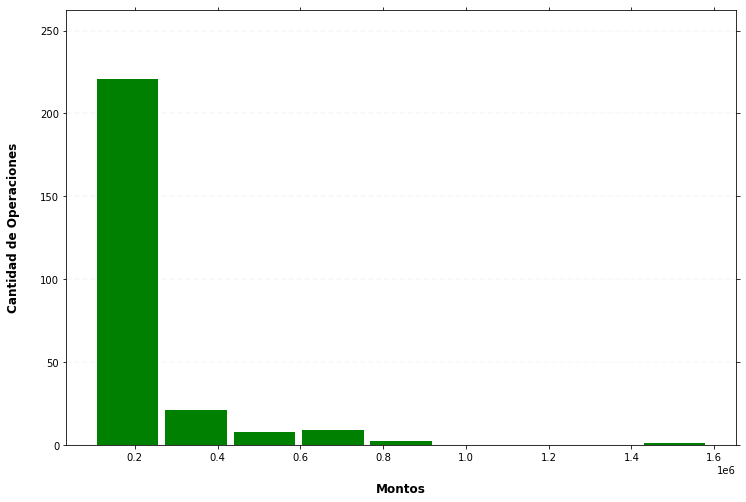

In [202]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_ent_grupo_sum_mul['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_ent_grupo_sum_mul_lim_excluir = df_trans_ent_grupo_sum_mul[df_trans_ent_grupo_sum_mul['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_ent_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_ent_grupo_sum_mul_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_ent_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_ent_grupo_sum_mul_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_ent_grupo_sum_mul_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_ent_grupo_sum_mul_lim_excluir_frec.index).value_counts()
df_trans_ent_grupo_sum_mul_lim_excluir_frec["Marca"]  = df_trans_ent_grupo_sum_mul_lim_excluir_frec.index.mid

display(df_trans_ent_grupo_sum_mul_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS OPERACIONES MULTIPLES***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
pd.options.display.float_format = '{:.2f}'.format

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_ent_grupo_sum_mul.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df_mult{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df_mult{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_mul_{i}_excluir'] = locals()[f'df_mult{i}'][locals()[f'df_mult{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_mul_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_mul_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_mul_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_mul_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_mul_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_mul_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_mul_{i}_frec_excluir']["Marca"]  = locals()[f'df_mul_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_mul_{i}_frec_excluir'])

****TRABAJANDO CON TRANSFERENCIAS SALIDAS****

In [216]:
df_trans_sal['NUMERO_DOC_ENT'] = df_trans_sal['Número Doc. Origen'] 

In [218]:
grupo = pd.DataFrame()
grupo = df_trans_sal.groupby(['NUMERO_DOC_ENT', 'ANIOMES']).NUMERO_DOC_ENT.size()
df_trans_sal_grupo = pd.DataFrame(grupo.reset_index(name='CUENTA_OP'))
df_trans_sal_grupo.sort_values(['NUMERO_DOC_ENT', 'ANIOMES'], ascending=False)
df_trans_sal_grupo['LLAVE'] = df_trans_sal_grupo['NUMERO_DOC_ENT'].astype(str) + df_trans_sal_grupo['ANIOMES'].astype(str)

grupo = pd.DataFrame()
grupo = df_trans_sal.groupby(['NUMERO_DOC_ENT', 'ANIOMES']).IMPORTE.sum()
df_trans_sal_sum = pd.DataFrame(grupo.reset_index(name='SUMA_OP'))
df_trans_sal_sum.sort_values(['NUMERO_DOC_ENT', 'ANIOMES'], ascending=False)
df_trans_sal_sum['LLAVE'] = df_trans_sal_sum['NUMERO_DOC_ENT'].astype(str) + df_trans_sal_sum['ANIOMES'].astype(str)

df_trans_sal_grupo_sum = df_trans_sal_grupo.merge(df_trans_sal_sum.drop_duplicates(subset=['LLAVE'])[['LLAVE', 'SUMA_OP']], left_on ='LLAVE', right_on='LLAVE', how='inner')
df_trans_sal_grupo_sum.sort_values(['CUENTA_OP', 'SUMA_OP'], ascending=False)

,NUMERO_DOC_ENT,ANIOMES,CUENTA_OP,LLAVE,SUMA_OP
16097,11111111.00,202202,702,11111111.0202202,333725.54
16096,11111111.00,202201,224,11111111.0202201,81197.94
118186,72839834.00,202110,81,72839834.0202110,72900.00
28581,40578102.00,202108,30,40578102.0202108,10500.00
28583,40578102.00,202111,29,40578102.0202111,10150.00
...,...,...,...,...,...
129818,75522638.00,202203,1,75522638.0202203,0.78
145024,70096137,202112,1,70096137202112,0.70
136903,77504664.00,202203,1,77504664.0202203,0.68
38413,41884523.00,202202,1,41884523.0202202,0.40


In [219]:
df_trans_sal_grupo_sum_unico = df_trans_sal_grupo_sum[df_trans_sal_grupo_sum['CUENTA_OP'] == 1]
df_trans_sal_grupo_sum_mul = df_trans_sal_grupo_sum[df_trans_sal_grupo_sum['CUENTA_OP'] > 1]

**PARTICIANDO DATAFRAME SEGUN EL MES Y AÑO**
 - Utilizamos la función locals para generar dataframes dinamicos)

In [221]:
#Particionar Dataframe df_trans_ent_grupo_sum_unico
for i, (ID, subdf) in enumerate(df_trans_sal_grupo_sum_unico.groupby('ANIOMES'), 1):
    locals()[f'df_sal_{ID}'] = subdf

#Particionar Dataframe df_trans_ent_grupo_sum_mult
for i, (ID, subdf) in enumerate(df_trans_sal_grupo_sum_mul.groupby('ANIOMES'), 1):
    locals()[f'df_sal_mult{ID}'] = subdf

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO CONSOLLIDADO DE TRANSFERENCIAS SALIDAS OPERACIONES UNICAS***

HISTOGRAMA CON TODAS PARTICIONES

In [225]:
## Imprimiendo Dataframe frecuencias
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

pd.set_option('precision', 2)
datos2 = df_trans_sal_grupo_sum_unico['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_sal_grupo_sum_unico_frec = pd.DataFrame(index=intervals)
df_trans_sal_grupo_sum_unico_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_sal_grupo_sum_unico_frec.index).value_counts()
df_trans_sal_grupo_sum_unico_frec["Marca"]  = df_trans_sal_grupo_sum_unico_frec.index.mid

display(df_trans_sal_grupo_sum_unico_frec)

,FreqAbs,Marca
Intervalo,,
"[0.13, 7059.004705882353)",110040,3529.57
"[7059.004705882353, 14117.879411764705)",11395,10588.44
"[14117.879411764705, 21176.75411764706)",4187,17647.32
"[21176.75411764706, 28235.628823529412)",1782,24706.19
"[28235.628823529412, 35294.50352941176)",1063,31765.07
"[35294.50352941176, 42353.37823529411)",517,38823.94
"[42353.37823529411, 49412.25294117647)",287,45882.82
"[49412.25294117647, 56471.12764705882)",233,52941.69
"[56471.12764705882, 63530.00235294117)",150,60000.56


HISTOGRAMA EXCLUYENDO PRIMERA PARTICIÓN 

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_sal_grupo_sum_unico['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_sal_grupo_sum_unico_lim_excluir = df_trans_sal_grupo_sum_unico[df_trans_sal_grupo_sum_unico['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_sal_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_sal_grupo_sum_unico_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_sal_grupo_sum_unico_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_sal_grupo_sum_unico_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_sal_grupo_sum_unico_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_sal_grupo_sum_unico_lim_excluir_frec.index).value_counts()
df_trans_sal_grupo_sum_unico_lim_excluir_frec["Marca"]  = df_trans_sal_grupo_sum_unico_lim_excluir_frec.index.mid

display(df_trans_sal_grupo_sum_unico_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS SALIDAS OPERACIONES UNICAS***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_sal_grupo_sum_unico.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df_sal_{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df_sal_{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_sal_{i}_excluir'] = locals()[f'df_sal_{i}'][locals()[f'df_sal_{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_sal_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_sal_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_sal_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_sal_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_sal_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_sal_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_sal_{i}_frec_excluir']["Marca"]  = locals()[f'df_sal_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_sal_{i}_frec_excluir'])

HISTOGRAMA EXCLUYENDO PRIMERA PARTICIÓN 

,FreqAbs,Marca
Intervalo,,
"[22300.0, 53442.653999999995)",447,37871.33
"[53442.653999999995, 84585.30799999999)",54,69013.98
"[84585.30799999999, 115727.96199999997)",21,100156.63
"[115727.96199999997, 146870.61599999998)",34,131299.29
"[146870.61599999998, 178013.26999999996)",2,162441.94
"[178013.26999999996, 209155.92399999994)",0,193584.60
"[209155.92399999994, 240298.57799999995)",1,224727.25
"[240298.57799999995, 271441.23199999996)",0,255869.90
"[271441.23199999996, 302583.88599999994)",0,287012.56


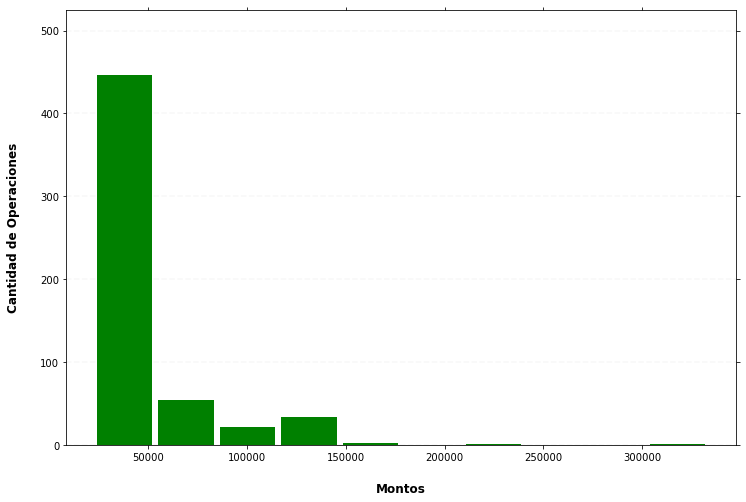

In [229]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df_trans_sal_grupo_sum_mul['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df_trans_sal_grupo_sum_mul_lim_excluir = df_trans_sal_grupo_sum_mul[df_trans_sal_grupo_sum_mul['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df_trans_sal_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df_trans_sal_grupo_sum_mul_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df_trans_sal_grupo_sum_mul_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df_trans_sal_grupo_sum_mul_lim_excluir_frec = pd.DataFrame(index=intervals)
df_trans_sal_grupo_sum_mul_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df_trans_sal_grupo_sum_mul_lim_excluir_frec.index).value_counts()
df_trans_sal_grupo_sum_mul_lim_excluir_frec["Marca"]  = df_trans_sal_grupo_sum_mul_lim_excluir_frec.index.mid

display(df_trans_sal_grupo_sum_mul_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS SALIDAS OPERACIONES MULTIPLES***

202108


,FreqAbs,Marca
Intervalo,,
"[12200.0, 29457.285714285714)",79,20828.64
"[29457.285714285714, 46714.57142857143)",19,38085.93
"[46714.57142857143, 63971.857142857145)",10,55343.21
"[63971.857142857145, 81229.14285714286)",0,72600.50
"[81229.14285714286, 98486.42857142857)",0,89857.79
"[98486.42857142857, 115743.71428571429)",0,107115.07
"[115743.71428571429, 133001.0)",1,124372.36


202109


,FreqAbs,Marca
Intervalo,,
"[15400.0, 37228.71428571429)",99,26314.36
"[37228.71428571429, 59057.42857142857)",12,48143.07
"[59057.42857142857, 80886.14285714286)",1,69971.79
"[80886.14285714286, 102714.85714285714)",1,91800.50
"[102714.85714285714, 124543.57142857143)",1,113629.21
"[124543.57142857143, 146372.2857142857)",0,135457.93
"[146372.2857142857, 168201.0)",1,157286.64


202110


,FreqAbs,Marca
Intervalo,,
"[12850.0, 28868.875)",127,20859.44
"[28868.875, 44887.75)",37,36878.31
"[44887.75, 60906.625)",17,52897.19
"[60906.625, 76925.5)",7,68916.06
"[76925.5, 92944.375)",1,84934.94
"[92944.375, 108963.25)",2,100953.81
"[108963.25, 124982.125)",1,116972.69
"[124982.125, 141001.0)",1,132991.56


202111


,FreqAbs,Marca
Intervalo,,
"[6920.0, 16292.625)",178,11606.31
"[16292.625, 25665.25)",48,20978.94
"[25665.25, 35037.875)",9,30351.56
"[35037.875, 44410.5)",11,39724.19
"[44410.5, 53783.125)",4,49096.81
"[53783.125, 63155.75)",2,58469.44
"[63155.75, 72528.375)",2,67842.06
"[72528.375, 81901.0)",1,77214.69


202112


,FreqAbs,Marca
Intervalo,,
"[9120.0, 22103.0)",57,15611.50
"[22103.0, 35086.0)",7,28594.50
"[35086.0, 48069.0)",1,41577.50
"[48069.0, 61052.0)",3,54560.50
"[61052.0, 74035.0)",0,67543.50
"[74035.0, 87018.0)",0,80526.50
"[87018.0, 100001.0)",1,93509.50


202201


,FreqAbs,Marca
Intervalo,,
"[11080.0, 26207.625)",155,18643.81
"[26207.625, 41335.25)",27,33771.44
"[41335.25, 56462.875)",7,48899.06
"[56462.875, 71590.5)",5,64026.69
"[71590.5, 86718.125)",2,79154.31
"[86718.125, 101845.75)",3,94281.94
"[101845.75, 116973.375)",2,109409.56
"[116973.375, 132101.0)",13,124537.19


202202


,FreqAbs,Marca
Intervalo,,
"[28000.0, 71675.21999999999)",52,49837.61
"[71675.21999999999, 115350.43999999997)",7,93512.83
"[115350.43999999997, 159025.65999999997)",9,137188.05
"[159025.65999999997, 202700.87999999995)",1,180863.27
"[202700.87999999995, 246376.09999999992)",0,224538.49
"[246376.09999999992, 290051.31999999995)",0,268213.71
"[290051.31999999995, 333726.5399999999)",1,311888.93


202203


,FreqAbs,Marca
Intervalo,,
"[17200.0, 42775.125)",163,29987.56
"[42775.125, 68350.25)",24,55562.69
"[68350.25, 93925.375)",8,81137.81
"[93925.375, 119500.5)",3,106712.94
"[119500.5, 145075.625)",9,132288.06
"[145075.625, 170650.75)",0,157863.19
"[170650.75, 196225.875)",0,183438.31
"[196225.875, 221801.0)",1,209013.44


202204


,FreqAbs,Marca
Intervalo,,
"[8000.0, 20700.5)",2,14350.25
"[20700.5, 33401.0)",1,27050.75


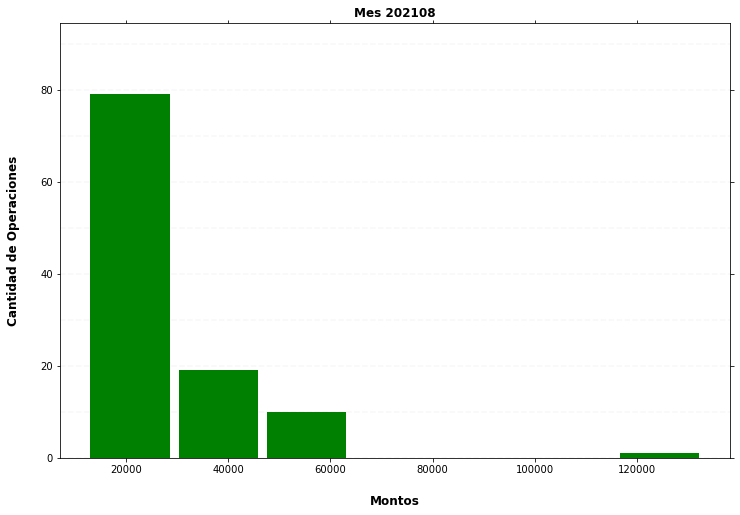

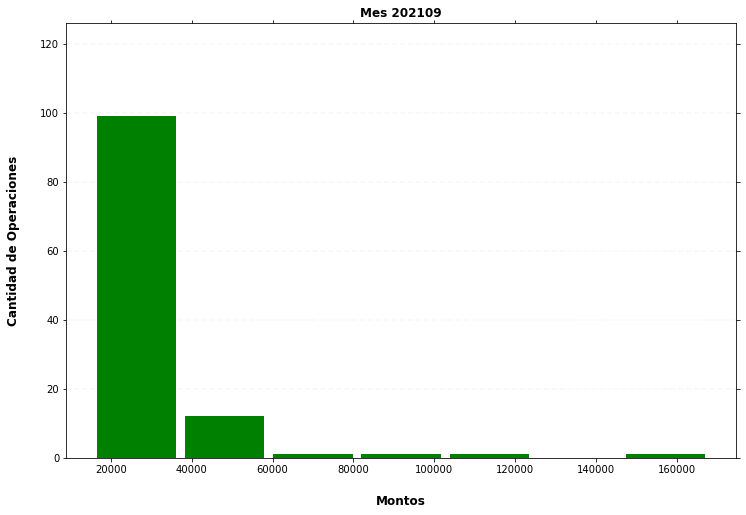

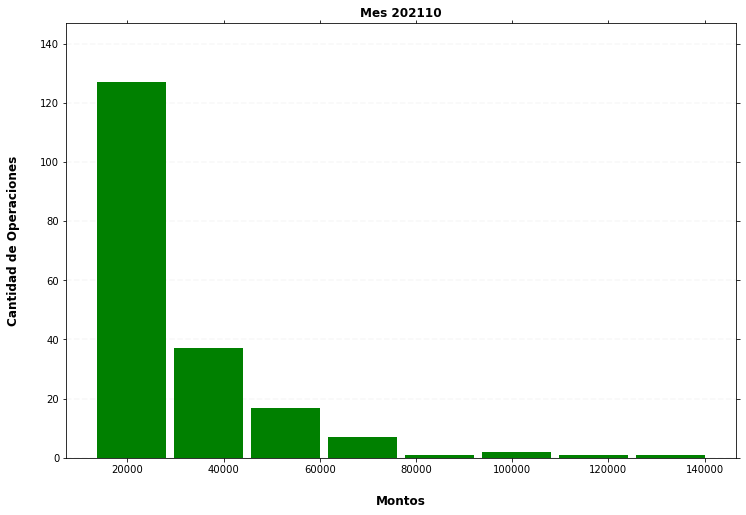

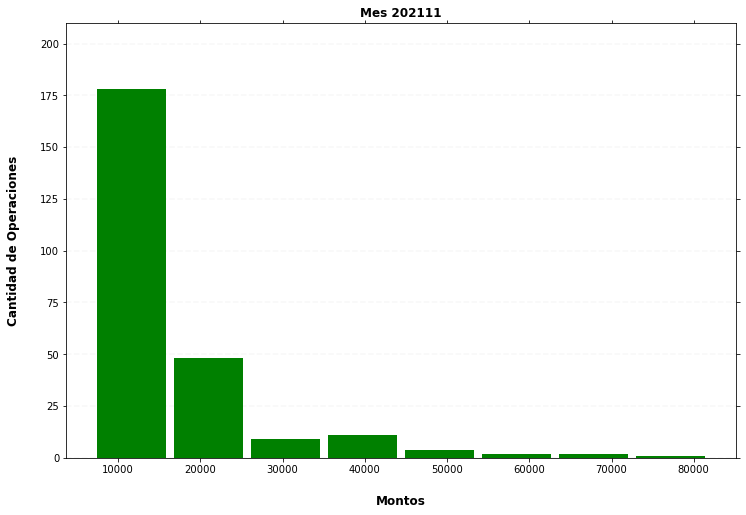

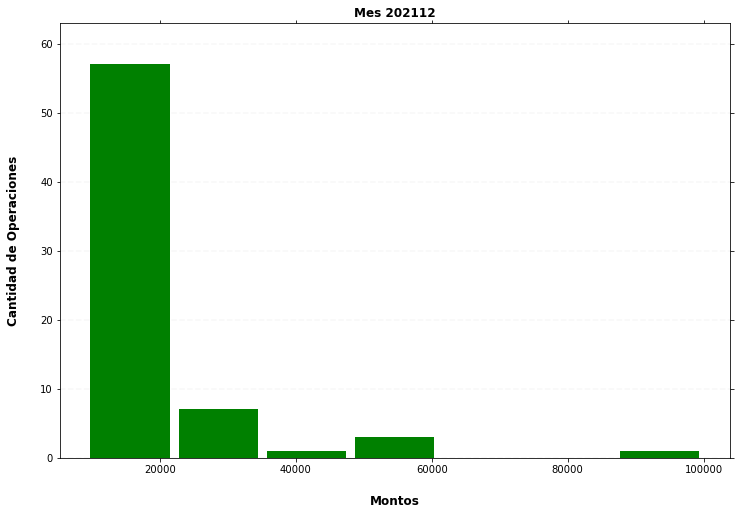

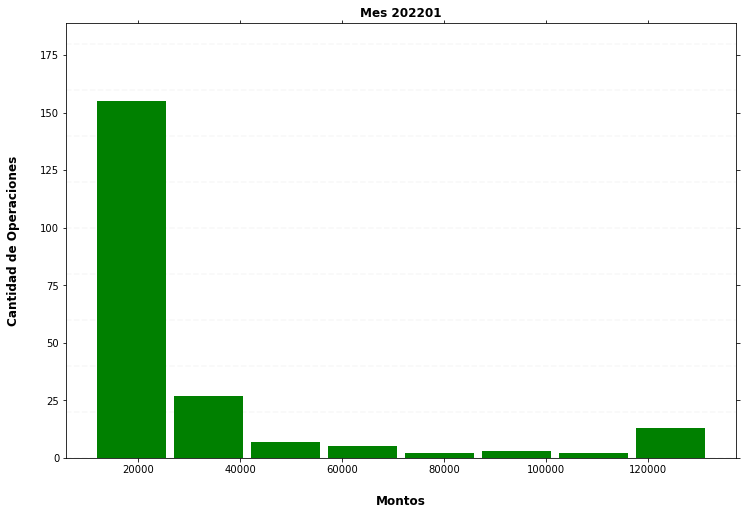

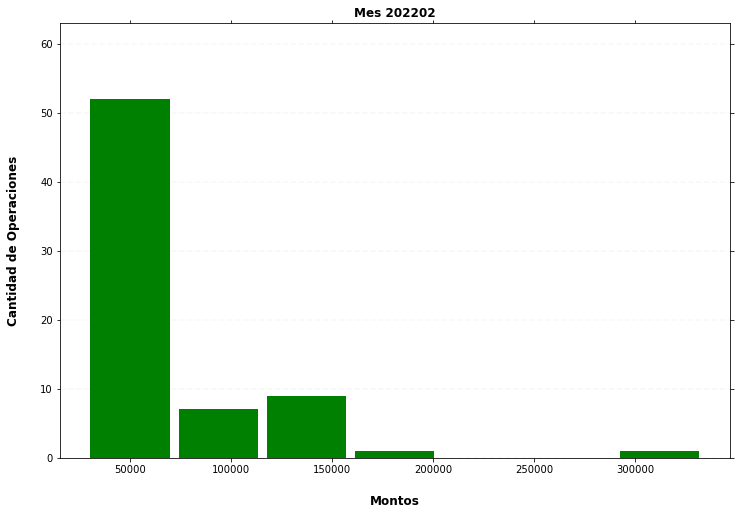

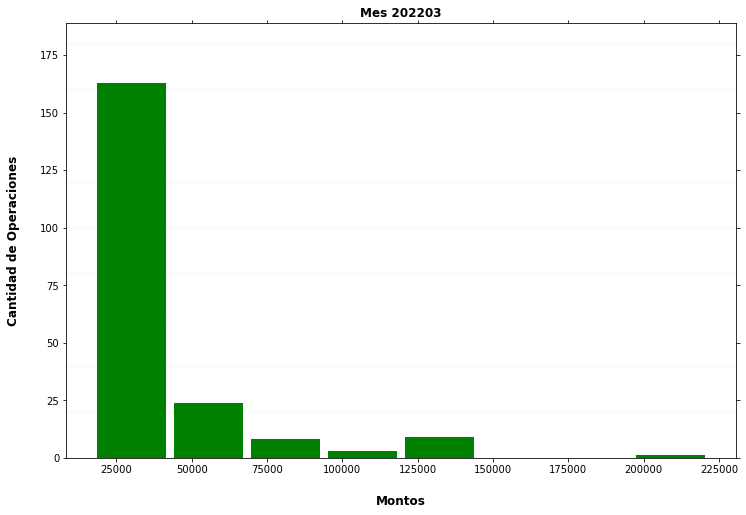

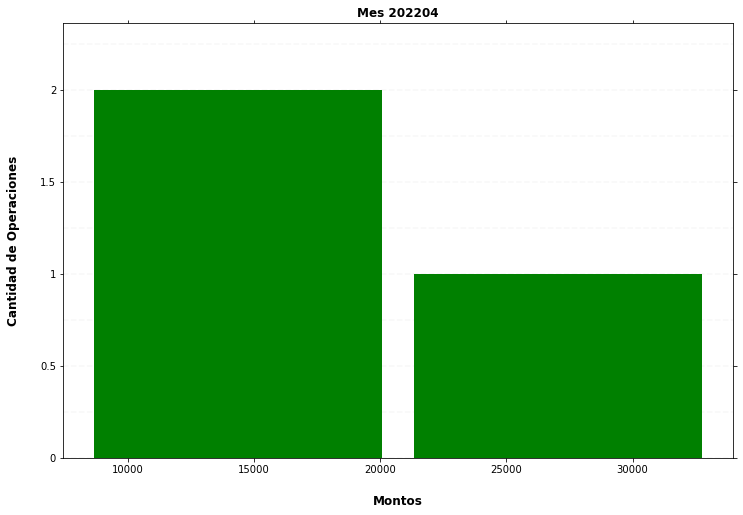

In [227]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
pd.options.display.float_format = '{:.2f}'.format

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_sal_grupo_sum_mul.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df_sal_mult{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df_sal_mult{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_sal_mul_{i}_excluir'] = locals()[f'df_sal_mult{i}'][locals()[f'df_sal_mult{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_sal_mul_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_sal_mul_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_sal_mul_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_sal_mul_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_sal_mul_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_sal_mul_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_sal_mul_{i}_frec_excluir']["Marca"]  = locals()[f'df_sal_mul_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_sal_mul_{i}_frec_excluir'])